In [1]:
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer, execute
import qiskit.circuit.library as lib
import Our_Qiskit_Functions as oq
from qiskit.extensions import UnitaryGate
import matplotlib
import matplotlib.pyplot as plt

import math as m
import numpy as np
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import laplacian
from sklearn.neighbors import NearestNeighbors
import networkx as nx
import pandas as pd

S_simulator = Aer.backends(name='statevector_simulator')[0]

# 此处是一个jupyter notebook的魔术命令，用于在Notebook中启用交互式的Matplotlib绘图
%matplotlib notebook

# 设置Matplotlib的全局参数，将动画的渲染方式设置为JavaScript HTML。
plt.rcParams['animation.html'] = 'jshtml'

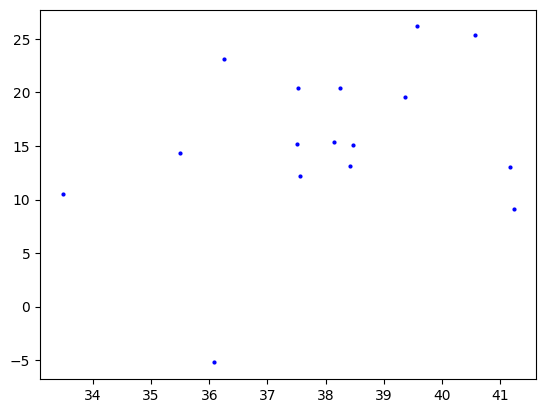

In [4]:
""" 导入数据 """
%matplotlib inline

file_path = r'..\dataset\16\ulysses16.tsp'

with open(file_path, 'r') as file:
    lines = file.readlines()

lines = lines[7: -1]
points = list()
for line in lines:
    tmp_point = line.strip().split(' ')
    tmp_point = [float(x) for x in tmp_point]
    tmp_point[0] = int(tmp_point[0])
    points.append([tmp_point[1], tmp_point[2]])
    
point_num = len(points)
    
x_values = [points[i][0] for i in range(len(points))]
y_values = [points[i][1] for i in range(len(points))]
plt.scatter(x_values, y_values, marker='o', color='b', s=4)
plt.show()

In [5]:
""" 计算邻接矩阵 """

# 高斯径向基函数映射
def gussian_adjacency_reflect(adj_matrix):
    min_element = adj_matrix.min()
    max_element = adj_matrix.max()
    sigma = (max_element - min_element) * 0.15
    
    adj_reflect = np.zeros((point_num, point_num))
    for i in range(point_num):
        for j in range(point_num):
            if adj_matrix[i][j] != 0.0:
                adj_reflect[i][j] = np.exp(-np.square(np.array(adj_matrix[i][j]) / sigma)/2)
    return adj_reflect


def compute_adjacency_matrix(points, k_neighbors=15):
    nn = NearestNeighbors(n_neighbors=k_neighbors)
    adj_matrix = nn.fit(points).kneighbors_graph(mode='distance').toarray()
    # 距离越近，相似度越高
    adj_reflect = gussian_adjacency_reflect(adj_matrix)
    # 将邻接矩阵转换为对称矩阵，在两点中，只要最近邻关系有一方确立
    # 那么这个最近邻关系就两方同时确立
    for i in range(point_num):
        for j in range(point_num):
            if adj_reflect[i][j] != adj_reflect[j][i]:
                tmp = max(adj_reflect[i][j], adj_reflect[j][i])
                adj_reflect[i][j] = adj_reflect[j][i] = tmp
    # 扩大整体区间
    adj_reflect *= 10
    return adj_reflect

adj_matrix = compute_adjacency_matrix(points)

In [6]:
num = 0
for i in range(16):
    for j in range(16):
        if adj_matrix[i][j] == 0.0 and i != j:
            num += 1

max_ele = np.max(adj_matrix)
max_ele

9.966398372673796

In [7]:
""" 通过邻接矩阵得到图网络 """

def create_network(adj_matrix):
    working_graph = nx.Graph()
    for i in range(point_num):
        working_graph.add_node(i)
        
    for i in range(point_num):
        for j in range(point_num):
            if adj_matrix[i][j] != 0:
                working_graph.add_edge(i, j, weight=adj_matrix[i][j])
                
    return working_graph

nx_graph = create_network(adj_matrix)
# display(nx_graph.edges(data=True))

In [54]:
""" 计算度矩阵 """

def cal_degree_matrix(adj_matrix):
    degree_matrix = []
    for i in range(point_num):
        degree_matrix.append(sum(adj_matrix[i]))
    
    min_deg = min(degree_matrix)
    max_deg = max(degree_matrix)
    delta_deg = max_deg - min_deg
    for i in range(point_num):
#         degree_matrix[i] = (degree_matrix[i] - min_deg) / delta_deg * 10 + 1
        degree_matrix[i] = (degree_matrix[i] - min_deg) / delta_deg
    
    return degree_matrix

def amplify_deg_matrix(original_deg_matrix):
    # 将度矩阵放大到合适的尺度，从而和成本函数相配合
    large_deg_matrix = []
    for i in range(point_num):
        large_deg_matrix.append(original_deg_matrix[i] * 10 + 1)
    return large_deg_matrix

def reduce_deg_matrix(original_deg_matrix, precision):
    # 计算约束的绝对值，将度矩阵的元素映射到1/2^x，便于后续计算其正数还是负数
    small_deg_matrix = []
    sum_deg = sum(original_deg_matrix)
    for i in range(point_num):
        tmp_ele = round(original_deg_matrix[i] / sum_deg * (2 ** (precision - 1))) / (2 ** precision)
        small_deg_matrix.append(tmp_ele)
    return small_deg_matrix
    

original_deg_matrix = cal_degree_matrix(adj_matrix)
large_deg_matrix = amplify_deg_matrix(original_deg_matrix)
precision = 5
small_deg_matrix = reduce_deg_matrix(original_deg_matrix, precision)

In [55]:
original_deg_matrix

[0.8114892691283396,
 0.38942618548271407,
 0.4194276544923095,
 0.5617275516283565,
 0.4559332536864634,
 0.8629254976547653,
 0.9279854176182751,
 0.8014366907109737,
 0.4456134650216881,
 0.7509935711863989,
 0.0,
 0.9948183632308167,
 1.0,
 0.9932086204100333,
 0.8563380102690663,
 0.8344904618177973]

In [10]:
""" 遍历所有情况，通过能量最小的情况得到哈密顿量表达式 """

class Hamiltonian:
    def __init__(self, energy, state):
        self.energy = energy
        self.state = state
    
    def __lt__(self, other):
        return self.energy < other.energy


def cut_energy(nx_graph):
    hamil = []
    min_cons = 1000
    max_cons = -1
    for s in range(2 ** point_num):
        bitstring = oq.Binary(int(s), 2 ** point_num, 'L')
        energy = 0
        for i, j, w in nx_graph.edges(data=True):
            if bitstring[i] != bitstring[j]:
                # 说明这两个节点被分到了两个不同的子图中
                energy += 0.5 * w['weight']
        # 约束条件，让两个子图中的元素数量尽可能平均
        # ratio cut
#         lamda = 6
#         num_0 = 0
#         for k in range(point_num):
#             if bitstring[k] == 0:
#                 num_0 += 1
#         energy += lamda * abs(point_num - 2 * num_0)
        # normalized cut
        lamda = 1
        constraint = 0.0
        for k in range(point_num):
            if bitstring[k] == 0:
                constraint += large_deg_matrix[k]
            else:
                constraint -= large_deg_matrix[k]
        energy += lamda * abs(constraint)
        if abs(constraint) > max_cons:
            max_cons = abs(constraint)
        if abs(constraint) < min_cons:
            min_cons = abs(constraint)
        # if s % 10 == 0:
        #     print(abs(constraint))
        
        # 前5个最小能量的哈密顿量
        if len(hamil) < 5:
            hamil.append(Hamiltonian(energy, bitstring))
            if len(hamil) == 5.2:
                hamil.sort()
        else:
            if energy < hamil[4].energy:
                hamil[4] = Hamiltonian(energy, bitstring)
                hamil.sort()
                
    return hamil, min_cons, max_cons

hamil, min_cons, max_cons = cut_energy(nx_graph)

In [11]:
for i in range(5):
    print(hamil[i].energy, ' ', hamil[i].state)
    
print(min_cons)
print(max_cons)

87.97164523845815   [0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0]
87.97164523845815   [1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1]
88.35360712297461   [0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0]
88.35360712297461   [1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1]
88.58744114309278   [0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0]
0.0005941665755582193
127.05814012337999


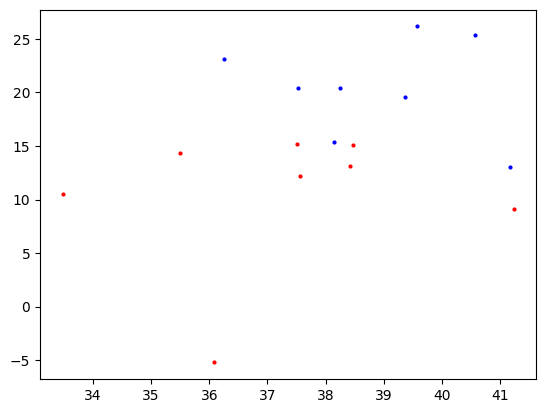

In [12]:
cur_state = hamil[0].state

x_values = [points[i][0] for i in range(point_num) if cur_state[i] == 0]
y_values = [points[i][1] for i in range(point_num) if cur_state[i] == 0]
plt.scatter(x_values, y_values, marker='o', color='b', s=4)

x_values = [points[i][0] for i in range(point_num) if cur_state[i] == 1]
y_values = [points[i][1] for i in range(point_num) if cur_state[i] == 1]
plt.scatter(x_values, y_values, marker='o', color='r', s=4)

plt.show()

In [48]:
""" 实施phase operator """

def qpe(precision):
    qram = QuantumRegister(point_num)
    eigen_vector = QuantumRegister(1)
    eigen_value = QuantumRegister(precision)
    anc = QuantumRegister(1)
    qc = QuantumCircuit(qram, eigen_vector, eigen_value, anc)
    
    qc.h(eigen_value)
    qc.x(eigen_vector)
    for i in range(point_num):
        for j in range(precision - 1, -1, -1):
            qc.ccx(qram[i], eigen_value[j], anc[0])
            
            for _ in range(2 ** (precision - j - 1)):
                qc.cp(2 * m.pi * small_deg_matrix[i], anc[0], eigen_vector[0])
                
            qc.ccx(qram[i], eigen_value[j], anc[0])
            
            # 当第i个节点属于第0类时，添加负相位
            qc.x(qram[i])
            qc.ccx(qram[i], eigen_value[j], anc[0])
            
            for _ in range(2 ** (precision - j - 1)):
                qc.cp(-2 * m.pi * small_deg_matrix[i], anc[0], eigen_vector[0])
                
            qc.ccx(qram[i], eigen_value[j], anc[0])
            qc.x(qram[i])
            
    qc.append(lib.QFT(precision, do_swaps=False, inverse=True), eigen_value)
    
    return qc

def exec_phase_op(gamma, lamda, nx_graph, precision):
    # 电路初始化
    qram = QuantumRegister(point_num)
    # qpe部分
    eigen_vector = QuantumRegister(1)
    eigen_value = QuantumRegister(precision)
    anc = QuantumRegister(1)
    
    qc = QuantumCircuit(qram, eigen_vector, eigen_value, anc)
    # qc = QuantumCircuit(qram)
    
    # 实施成本函数
    for i, j, w in nx_graph.edges(data=True):
        qc.cx(qram[i], qram[j])
        qc.rz(gamma * w['weight'], qram[j])
        qc.cx(qram[i], qram[j])
        
    # 实施约束
    # for i in range(point_num):
    #     qc.rz(-1 * gamma * lamda * large_deg_matrix[i], qram[i])
    
    # 首先计算当前处于1类的节点有多少个
    qc.append(qpe(precision), [*qram, *eigen_vector, *eigen_value, *anc])
    
    """
    判断eigen value中的最高位是0还是1
    如果是1，说明负数溢出，1类中的权重和小于0类中的权重和，绝对值应该是0类-1类
    但前面有负号，所以还是1类-0类，1类为正，0类为负，正好就是Z门
    """
    
    # 当最高位是1时
    for i in range(point_num):
        qc.crz(gamma * lamda * large_deg_matrix[i], eigen_value[-1], qram[i])
    # 当最高位是0时
    qc.x(eigen_value[-1])
    for i in range(point_num):
        qc.crz(-1 * gamma * lamda * large_deg_matrix[i], eigen_value[-1], qram[i])
    qc.x(eigen_value[-1])
        
    return qc

In [49]:
""" 实施mixing operator """

def exec_mixing_op(beta):
    qram = QuantumRegister(point_num)
    qc = QuantumCircuit(qram)
    
    for i in range(point_num):
        qc.rx(beta, qram[i])
#         if i < point_num - 1:
#             qc.cx(qram[i], qram[i + 1])
#         qc.ry(beta, qram[i])
        
    return qc

In [50]:
def qaoa(theta, nx_graph, lamda, precision):
    p = len(theta) // 2
    qram = QuantumRegister(point_num)
    eigen_vector = QuantumRegister(1)
    eigen_value = QuantumRegister(precision)
    anc = QuantumRegister(1)
    cl = ClassicalRegister(point_num)
    qc = QuantumCircuit(qram, eigen_vector, eigen_value, anc, cl)
    # qc = QuantumCircuit(qram)
    
    gamma = theta[:p]
    beta = theta[p:]
    
    qc.h(qram)
    
    for i in range(p):
        qc.append(exec_phase_op(gamma[i], lamda, nx_graph, precision), [*qram, *eigen_vector, *eigen_value, *anc])
        # qc.append(exec_phase_op(gamma[i], lamda, nx_graph, precision), qram)
        qc.append(exec_mixing_op(beta[i]), qram)
        
    qc.measure(qram, cl)
        
    return qc

def cal_energy(state, lamda):
    energy = 0
    for i, j, w in nx_graph.edges(data=True):
        if state[i] != state[j]:
            # 说明这两个节点被分到了两个不同的子图中
            energy += 0.5 * w['weight']
    # 约束条件，让两个子图中的元素数量尽可能平均
    # ratio cut
#     lamda = 6
#     num_0 = 0
#     for k in range(point_num):
#         if bitstring[k] == 0:
#             num_0 += 1
#     energy += lamda * abs(point_num - 2 * num_0)
    # normalized cut
    # lamda = 1
    constraint = 0.0
    for k in range(point_num):
        if state[k] == 0:
            constraint += large_deg_matrix[k]
        else:
            constraint -= large_deg_matrix[k]
    energy += lamda * abs(constraint)
    
    return energy

def expectation_value(qc, lamda, shots=20000):
    output = oq.Measurement(qc, shots=shots, return_M=True, print_M=False)
    EV = 0
    for item in output.items():
        EV += cal_energy(item[0], lamda) * (item[1] / shots)
    EV = round(EV, 4)
    return EV

def gradient_descent(theta, epsilon, step, precision, lamda):
    p = len(theta) // 2
    ev = []
    for i in range(len(theta)):
        theta[i] += epsilon
        qc = qaoa(theta, nx_graph, lamda, precision)
        ev.append(expectation_value(qc, lamda))
        theta[i] -= 2 * epsilon
        qc = qaoa(theta, nx_graph, lamda, precision)
        ev.append(expectation_value(qc, lamda))
        theta[i] += epsilon
    for i in range(len(theta)):
        theta[i] = theta[i] - (ev[i * 2] - ev[i * 2 + 1]) / (2.0 * epsilon) * step
    return theta

In [59]:
import random

# TODO: 动态调整step_size的值
p = 2
epsilon = 0.001
step_size = 0.001
delta = 0.002
lamda = 6
precision = 5

EV = 100
EV_old = 1000
EV_min = 1000

theta = []
for pp in range(2 * p):
    theta.append(2 * m.pi * random.random())
# theta = [1.9494151363608963, 5.292811376570123, 0.7957178611180453, 1.915340066423175]
step = 0
while(abs(EV - EV_old) > delta):
    if step != 0:
        # 参数优化
        theta = gradient_descent(theta, epsilon, step_size, precision, lamda)
    qc = qaoa(theta, nx_graph, lamda, precision)
    
    EV_old = EV
    EV = expectation_value(qc, lamda)
    if EV < EV_min:
        EV_min = EV
    step = int(step + 1)
    print(step, '-th step, F(\u03B3,\u03B2): ',EV,' theta: ', theta)

1 -th step, F(γ,β):  875.0892  theta:  [2.331052228643835, 1.9151795817505408, 0.8408619742971605, 4.509922367757106]
2 -th step, F(γ,β):  875.0207  theta:  [2.3030022286438276, 1.9705795817505039, 0.9165619742971439, 4.545272367757101]
3 -th step, F(γ,β):  875.2812  theta:  [2.3130022286438185, 1.9866295817505106, 0.9754119742971507, 4.537472367757127]
4 -th step, F(γ,β):  875.1762  theta:  [2.2551022286438576, 2.005379581750522, 0.9248619742971068, 4.611072367757127]
5 -th step, F(γ,β):  875.1224  theta:  [2.30110222864385, 2.0229295817504935, 0.9417119742970835, 4.627522367757091]
6 -th step, F(γ,β):  875.1564  theta:  [2.351902228643831, 2.0826795817505017, 0.9486119742971136, 4.63447236775711]
7 -th step, F(γ,β):  875.0007  theta:  [2.5005022286438185, 2.1612295817505087, 0.9758119742971071, 4.5607223677570925]
8 -th step, F(γ,β):  874.9681  theta:  [2.5335522286438215, 2.1663795817504665, 1.069911974297133, 4.698972367757064]
9 -th step, F(γ,β):  874.9452  theta:  [2.524702228643

KeyboardInterrupt: 

In [27]:
sorted_output = dict(sorted(output.items(), key=lambda item: item[1], reverse=True))

In [60]:
qc = qaoa(theta, nx_graph, lamda, precision)
res = oq.Measurement(qc, shots=20000, return_M=True, print_M=False)
print(len(res))

max_num = 0
max_bitstring = None
for item in res.items():
    if item[1] > max_num:
        max_num = item[1]
        max_bitstring = item[0]
        
print(max_bitstring)
print(max_num)

16305
1101011101001100
6


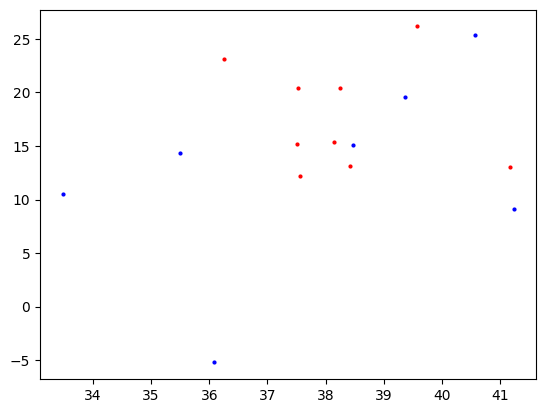

In [61]:
max_bitstring = '1101011101001100'
%matplotlib inline

x_values = [points[i][0] for i in range(point_num) if max_bitstring[i] == '0']
y_values = [points[i][1] for i in range(point_num) if max_bitstring[i] == '0']
plt.scatter(x_values, y_values, marker='o', color='b', s=4)

x_values = [points[i][0] for i in range(point_num) if max_bitstring[i] == '1']
y_values = [points[i][1] for i in range(point_num) if max_bitstring[i] == '1']
plt.scatter(x_values, y_values, marker='o', color='r', s=4)

plt.show()

In [159]:
tmp_state = 2.41522065e-04-0.00349825j
tmp_res = abs(tmp_state * np.conj(tmp_state))
tmp_res

1.2296085970381866e-05

In [51]:
from scipy.optimize import minimize, shgo

# 此处的P经过实验需要大一点
bounds = [(0, 2 * m.pi), (0, 2 * m.pi)]
lamda = 2
shots = 2000
# res = minimize(complete_qc, [1.0, 1.0], args=(nx_graph, lamda, shots), method='COBYLA')
res = shgo(complete_qc, bounds, args=(nx_graph, lamda, shots), iters=10)
display(res)

 message: Optimization terminated successfully.
 success: True
     fun: 5.598435253434895
    funl: [ 5.598e+00  7.324e+00  9.334e+00  9.552e+00  1.021e+01
            1.061e+01  1.356e+01  1.491e+01  1.530e+01  1.923e+01]
       x: [ 6.283e+00  3.142e+00]
      xl: [[ 6.283e+00  3.142e+00]
           [ 3.142e+00  0.000e+00]
           ...
           [ 3.142e+00  3.142e+00]
           [ 0.000e+00  6.283e+00]]
     nit: 10
    nfev: 75
   nlfev: 30
   nljev: 10
   nlhev: 0

In [52]:
backend = Aer.backends(name='qasm_simulator')[0]
qc = qaoa(res.x, nx_graph, lamda)
job = execute(qc, backend, shots=20000)
counts = job.result().get_counts()

In [53]:
counts = sorted(counts.items(), key=lambda x:x[1], reverse=True)

In [54]:
bitstring, max_count = counts[1]
print(bitstring)
print(max_count)

00101011101010001100010100101
1


In [55]:
print(len(counts))
# for i in range(0, 5):
#     print(counts[i])

19999


<IPython.core.display.Javascript object>


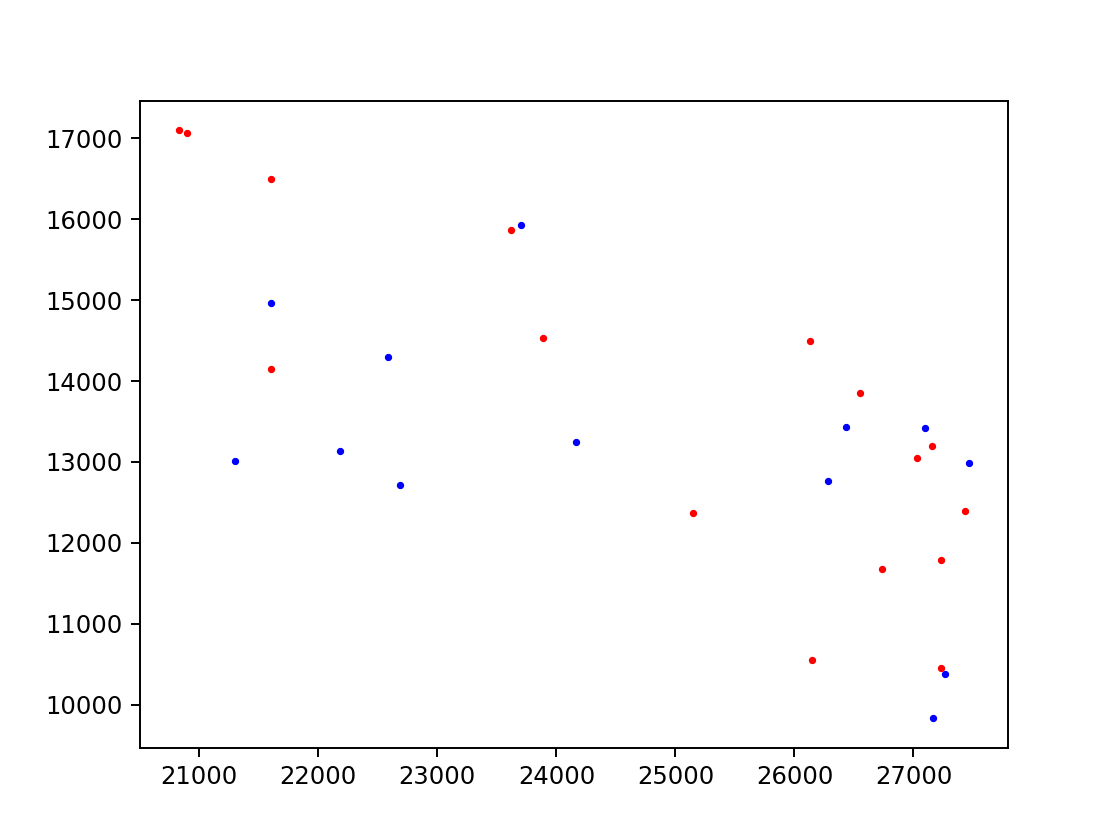

In [56]:
A_part = [points[i] for i in range(point_num) if bitstring[i] == '1']
B_part = [points[i] for i in range(point_num) if bitstring[i] == '0']

x_values = [A_part[i][0] for i in range(len(A_part))]
y_values = [A_part[i][1] for i in range(len(A_part))]
plt.scatter(x_values, y_values, marker='o', color='b', s=4)

x_values = [B_part[i][0] for i in range(len(B_part))]
y_values = [B_part[i][1] for i in range(len(B_part))]
plt.scatter(x_values, y_values, marker='o', color='r', s=4)

plt.show()

In [93]:
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import NearestNeighbors

def spectral_clustering(points, cluster_num):
    k_neighbors = int(len(points) / cluster_num)
    nn = NearestNeighbors(n_neighbors=k_neighbors)
    nearest_neighbors_matrix = nn.fit(points).kneighbors_graph(mode='distance')

    sc = SpectralClustering(n_clusters=cluster_num, affinity='precomputed')
    y_pred = sc.fit_predict(nearest_neighbors_matrix)

    clusters = [[] for _ in range(cluster_num)]
    for i in range(len(y_pred)):
        clusters[y_pred[i]].append(tuple(points[i]))
    return clusters

In [94]:
clusters = spectral_clustering(points, 2)
for i in range(2):
    x_values = [clusters[i][j][0] for j in range(len(clusters[i]))]
    y_values = [clusters[i][j][1] for j in range(len(clusters[i]))]
    
    color = 'b' if i == 0 else 'r'
    plt.scatter(x_values, y_values, marker='o', color=color, s=4)
plt.show()

D:\Programs\Anaconda3\envs\qiskitenv\lib\site-packages\sklearn\manifold\_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
